In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter

import random

%matplotlib inline

Using TensorFlow backend.


In [3]:
mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

imapping = {
    'Angry': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happy': 3,
    'Sad': 4,
    'Surprise': 5,
    'Neutral': 6
}


def flip_horizontally(image):
    return np.flip(image, axis=1)


def add_noise(image):
    return image + np.random.poisson(image.astype('float64'))


def rotate_right(image, angle=-20):
    return rotate(image, angle, mode='reflect', reshape=False)


def rotate_left(image, angle=20):
    return rotate(image, angle, mode='reflect', reshape=False)


def add_blur(image):
    return gaussian_filter(image, sigma=1)


def find_subsets(df: pd.DataFrame, class_to_fraction: dict):
    """
    select random subsets for given classes with given fractions
    :param df: data
    :param class_to_fraction: dictionary {'emotion' : fraction of the data to that is going to be augmented}
    :return: indices of the images to augmented
    """
    data = df.loc[df['y'].isin(class_to_fraction.keys())]
    indices = []
    for emotion in class_to_fraction.keys():
        temp = data.loc[data['y'] == emotion]
        indices = indices + random.sample(temp.index.tolist(), int(class_to_fraction[emotion] * len(temp)))

    return indices
  
class Augmenter:

    @staticmethod
    def augment_images(df: pd.DataFrame, 
                       target_file: str = None, 
                       class_to_fraction: dict = {'Disgust': 1}, 
                       augmentations: list = ['flip']) -> pd.DataFrame:

        # df = pd.read_csv(source_file)

        df['category'] = df['category'].str.strip()

        del df['Unnamed: 0']

        df['y'] = df['y'].map(mapping)

        indices = find_subsets(df, class_to_fraction)

        print(len(indices))
        temp = []

        if 'flip' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + flip_horizontally(
                    np.array(df.iloc[index, 1:2305]).reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'noise' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + add_noise(
                    np.array(df.iloc[index, 1:2305]).reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'rotate_right' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + rotate_right(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'rotate_left' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + rotate_left(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        if 'blur' in augmentations:
            for index in indices:
                temp.append([df.iloc[index, 0]] + add_blur(
                    np.array(df.iloc[index, 1:2305], dtype='int').reshape((48, 48))).flatten().tolist() + [df.iloc[index, 2305]])

        print(len(temp))

        data = pd.DataFrame(temp, columns=df.columns)

        if target_file:
            data.to_csv(target_file)

        return data

In [4]:
df = pd.read_csv('emotions.csv')

ctf = {
    'Disgust': 1,
    'Fear': 0.5,
    'Angry': 0.5,
    'Surprise': 0.1,
    'Happy': 0.1,
    'Sad': 0.1,
    'Neutral': 0.1
}

df['category'] = df['category'].str.strip()

train = df.loc[df.category == 'Training',:]
valid = df.loc[df.category == 'PublicTest',:]
test  = df.loc[df.category == 'PrivateTest',:]

aug = Augmenter.augment_images(train.copy(), None, ctf, ['flip', 'rotate_right', 'rotate_left', 'blur', 'noise'])

del train['Unnamed: 0']
del valid['Unnamed: 0']
del test['Unnamed: 0']

aug['y'] = aug['y'].map(imapping)

train = train.append(aug.sample(frac=1), ignore_index=True)

X_train = np.array(train.iloc[:, 1:2305])
y_train = np.array(train.loc[:, ['y']])

X_val = np.array(valid.iloc[:, 1:2305])
y_val = np.array(valid.loc[:, ['y']])

X_test = np.array(test.iloc[:, 1:2305])
y_test = np.array(test.loc[:, ['y']])

del train
del valid
del test

6498
32490


In [5]:
y_train = keras.utils.to_categorical(y_train, 7)
y_val = keras.utils.to_categorical(y_val, 7)
y_test = keras.utils.to_categorical(y_test, 7)

X_train_r = X_train.reshape((len(X_train), 48, 48))
X_val_r   = X_val.reshape((len(X_val), 48, 48))
X_test_r   = X_test.reshape((len(X_test), 48, 48))

del X_train
del X_val
del X_test

X_train_r = X_train_r / 255
X_val_r = X_val_r / 255
X_test_r = X_test_r / 255

# X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
# X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
# X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)

X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))

In [6]:
from keras import backend as K
from keras.applications.vgg19 import VGG19

from keras.metrics import categorical_accuracy

from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

np.random.seed(100)

### Alexnet model

In [7]:
model = Sequential()

model.add(Conv2D(96,(5,5), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384,(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(384,(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(256,(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 96)        2496      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       98560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 256)       1024      
__________

In [9]:
model.load_weights('alexnet.h5')

In [10]:
history = model.fit(X_train_bw, y_train, batch_size=256, epochs=100, validation_data=(X_val_bw, y_val))

Train on 61199 samples, validate on 3589 samples
Epoch 1/100
61199/61199 [==============================] - 95s 2ms/step - loss: 1.1112 - categorical_accuracy: 0.6237 - val_loss: 1.0871 - val_categorical_accuracy: 0.6071
Epoch 2/100
61199/61199 [==============================] - 79s 1ms/step - loss: 0.9450 - categorical_accuracy: 0.6543 - val_loss: 1.0153 - val_categorical_accuracy: 0.6439
Epoch 3/100
61199/61199 [==============================] - 79s 1ms/step - loss: 0.9057 - categorical_accuracy: 0.6709 - val_loss: 1.0825 - val_categorical_accuracy: 0.6328
Epoch 4/100
61199/61199 [==============================] - 79s 1ms/step - loss: 0.8955 - categorical_accuracy: 0.6738 - val_loss: 1.2363 - val_categorical_accuracy: 0.5701
Epoch 5/100
61199/61199 [==============================] - 79s 1ms/step - loss: 0.8711 - categorical_accuracy: 0.6832 - val_loss: 1.0383 - val_categorical_accuracy: 0.6453
Epoch 6/100
61199/61199 [==============================] - 79s 1ms/step - loss: 0.8529 - ca

61199/61199 [==============================] - 78s 1ms/step - loss: 0.4538 - categorical_accuracy: 0.8359 - val_loss: 1.2355 - val_categorical_accuracy: 0.6506
Epoch 96/100
61199/61199 [==============================] - 78s 1ms/step - loss: 0.4550 - categorical_accuracy: 0.8348 - val_loss: 1.2182 - val_categorical_accuracy: 0.6498
Epoch 97/100
61199/61199 [==============================] - 78s 1ms/step - loss: 0.4457 - categorical_accuracy: 0.8388 - val_loss: 1.2135 - val_categorical_accuracy: 0.6590
Epoch 98/100
61199/61199 [==============================] - 78s 1ms/step - loss: 0.4504 - categorical_accuracy: 0.8377 - val_loss: 1.3593 - val_categorical_accuracy: 0.6121
Epoch 99/100
61199/61199 [==============================] - 78s 1ms/step - loss: 0.4471 - categorical_accuracy: 0.8398 - val_loss: 1.2357 - val_categorical_accuracy: 0.6523
Epoch 100/100
61199/61199 [==============================] - 78s 1ms/step - loss: 0.4462 - categorical_accuracy: 0.8388 - val_loss: 1.2868 - val_cat

In [11]:
print(history.history.keys())

dict_keys(['val_loss', 'categorical_accuracy', 'val_categorical_accuracy', 'loss'])


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


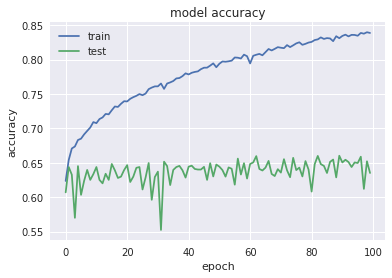

In [16]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


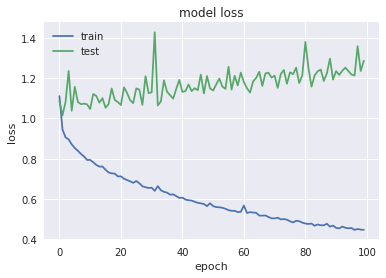

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.evaluate(X_test_bw, y = y_test, verbose=1)

3589/3589 [==============================] - 2s 578us/step


[1.2168673389002487, 0.6430760657730857]

In [20]:
model.save_weights('augmented-alexnet.h5')

In [21]:
model_json = model.to_json()

with open("augmented-alexnet.json", "w") as json_file:
    json_file.write(model_json)